<a href="https://colab.research.google.com/github/dh610/ai-intensive2/blob/main/lab7/quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ai-intensive2
!git pull
%cd lab7

Mounted at /content/drive
/content/drive/MyDrive/ai-intensive2
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.53 KiB | 1024 bytes/s, done.
From https://github.com/dh610/ai-intensive2
   1ac028b..769f300  main       -> origin/main
Updating 1ac028b..769f300
Fast-forward
 lab7/RNN-character.ipynb | 85 ++++++++++++++++++++++++++++++++++++++++++++++++++++----------------
 1 file changed, 65 insertions(+), 20 deletions(-)
/content/drive/MyDrive/ai-intensive2/lab7


# 퀴즈: GRU, LSTM 구현하기
- RNN 구현체를 참고하여 GRU, LSTM을 직접 구현해봅시다.
- 구현 난이도를 낮추기 위해 배치 크기는 전부 1로 가정했습니다. 배치는 신경쓰지 않아도 됩니다!

## 참고: RNN
![](https://i.imgur.com/Z2xbySO.png)

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)

        # update the hidden state
        hidden = self.i2h(combined)

        # make a output from input and previous hidden
        output = self.i2o(combined)

        # calculate softmax for multi-class classification
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# GRU (Gated Recurrent Unit)

![](https://t1.daumcdn.net/cfile/tistory/9982923F5ACB86A10E)

대괄호는 concatenation을 의미합니다.<br/>


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# F.sigmoid, F.tanh 사용

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.wz = nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        self.wr = nn.Linear(input_size + hidden_size, hidden_size)
        self.w = nn.Linear(input_size + hidden_size, hidden_size) # H tilde t

    def forward(self, input, hidden):
        """
            @parameters
              - input: Tensor [sequence_length, input_size]
              - hidden: Tensor [1, input_size]

            @returns
              - outputs: Tensor [sequence_length, output_size]
                -> sequence의 각 step에서의 hidden state를 반환.

              - hidden_state: Tensor [1, output_size]
                -> 마지막 hidden state를 반환
        """
        ht = hidden
        output = []

        for step in input:
            # (hidden, ) 차원을 -> (1, hidden)으로 바꿔서 맞춰준다.
            step = step.unsqueeze(0)
            combined = torch.cat((step, ht), 1)

            #####
            # 구현해봅시다!
            zt = self.wz(combined).sigmoid() # F.sigmoid()
            rt = self.wr(combined).sigmoid()
            htt = F.tanh(self.w(torch.cat((rt * ht, step), 1)))

            ht = (1 - zt) * ht + zt * htt
            output.append(ht)

        return torch.cat(output), ht

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

gru = GRU(4, 8)
outputs, hidden = gru (
    torch.rand((4, 4)),
    gru.initHidden(),
)

assert outputs.shape == (4, 8)
assert hidden.shape == (1, 8)
print("success!")

success!


## LSTM

<!-- ![](https://miro.medium.com/v2/resize:fit:1400/1*7cMfenu76BZCzdKWCfBABA.png) -->

<!-- ![](https://velog.velcdn.com/images/choonsik_mom/post/5cf21a79-01e4-4f7d-bb12-9af5ef0dcab2/image.png) -->
![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ChEmnSUZuqDXCygiWHfFfg.png)


x_t*Ui + h_t-1 * Wi 는  X_t와 h_t-1 를 concat 한 다음 linear 레이어를 거친다는(W 행렬곱) 의미입니다.

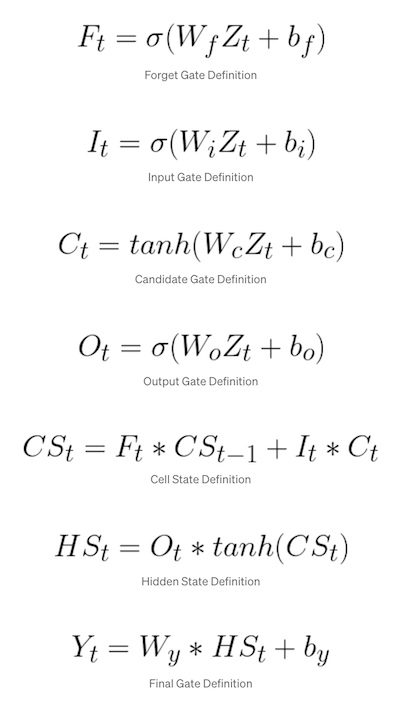

In [4]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size

        ## 필요한 레이어를 추가합시다!
        ##
        ##
        #self.wf = nn.Linear(input_size + hidden_size, hidden_size)
        #self.wi = nn.Linear(input_size + hidden_size, hidden_size)
        #self.wc = nn.Linear(input_size + hidden_size, hidden_size)
        #self.wo = nn.Linear(input_size + hidden_size, hidden_size)


        self.F_t = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Sigmoid(),
        )
        self.I_t = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Sigmoid(),
        )
        self.C_t = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh(),
        )
        self.O_t = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Sigmoid(),
        )
        self.tanh = nn.Tanh()


    def forward(self, input, hidden_state, cell_state):
        """
            @parameters
              - input: Tensor [sequence_length, input_size]
              - hidden_state: Tensor [1, input_size]
              - cell_state: Tensor [1, input_size]

            @returns
              - outputs: Tensor [sequence_length, output_size]
                -> sequence의 각 step에서의 final gate의 output 반환.

              - hidden_state: Tensor [1, output_size]
                -> 마지막 hidden state를 반환

              - cell_state: Tensor [1, output_size]
                -> 마지막 cell state를 반환

        """
        ht = hidden_state
        ct = cell_state
        output = []

        for step in input:
            # (hidden, ) 차원을 -> (1, hidden)으로 바꿔서 맞춰준다.
            step = step.unsqueeze(0)

            Zt = torch.cat((step, ht), 1)

            ## 구현해봅시다!!!

            ct = self.F_t(Zt) * ct + self.I_t(Zt) * self.C_t(Zt)
            ht = self.O_t(Zt) * self.tanh(ct)
            step_output = ht
            output.append(step_output)

        outputs = torch.cat(output, dim=0)

        return outputs, ht, ct

    def initHidden(self):
        # return hidden_state, cell_state
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))


lstm = LSTM(4, 8)
outputs, hidden, cell = lstm(
    torch.rand((4, 4)),
    *lstm.initHidden(),
)

assert outputs.shape == (4, 8)
assert hidden.shape == (1, 8)
assert cell.shape == (1, 8)
print("success!")

success!


Reference
- https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr
- https://velog.io/@choonsik_mom/pytorch%EB%A1%9C-LSTM-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0